# Import Libraries

In [49]:
from pylab import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import time
from scipy.misc import imread
from scipy.misc import imresize
import matplotlib.image as mpimg
from scipy.ndimage import filters
import urllib
from numpy import random
import copy
import math
from __future__ import division

import cPickle

import os
from scipy.io import loadmat

In [2]:
#plt.show() in jupyter notebook
%matplotlib inline

# Part 1

#### Analysis Data

In [51]:
def Counts(d):
    '''
    input: a list of lists of strings that represents one new title
    output: a dictionary that contains every word appeared and its count. To be precise, key is word and value is count.
    '''
    wordsCounts = {}
    for i in d:
        temp = []
        for j in i:
            if j in temp:
                continue
            else:
                temp.append(j)
                if j not in wordsCounts:
                    wordsCounts[j] = 1.0
                else:
                    wordsCounts[j] += 1.0

    return wordsCounts

the 1-th most prevealing word in fake news is trump :1282
the 2-th most prevealing word in fake news is to :366
the 3-th most prevealing word in fake news is the :363
the 4-th most prevealing word in fake news is donald :228
the 5-th most prevealing word in fake news is in :218
the 6-th most prevealing word in fake news is of :197
the 7-th most prevealing word in fake news is for :196
the 8-th most prevealing word in fake news is a :172
the 9-th most prevealing word in fake news is and :166
the 10-th most prevealing word in fake news is on :160


the 1-th most prevealing word in real news is trump :1739
the 2-th most prevealing word in real news is donald :828
the 3-th most prevealing word in real news is to :380
the 4-th most prevealing word in real news is us :230
the 5-th most prevealing word in real news is trumps :219
the 6-th most prevealing word in real news is in :213
the 7-th most prevealing word in real news is on :204
the 8-th most prevealing word in real news is of :181
the

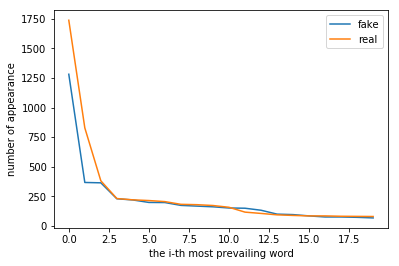

In [52]:
#import fakeData and realData from text files
fakeData = [line.rstrip('\n').split(' ') for line in open('clean_fake.txt')]
realData = [line.rstrip('\n').split(' ') for line in open('clean_real.txt')]

#count words in realData and fakeData
fakeWordsCounts = Counts(fakeData)
realWordsCounts = Counts(realData)
            
#sort words according to how often they appear
fakeWordsInOrder = sorted(fakeWordsCounts, key = fakeWordsCounts.__getitem__, reverse=True)
realWordsInOrder = sorted(realWordsCounts, key = realWordsCounts.__getitem__, reverse=True)

#plot
fig = plt.figure(11)
plt.plot(range(20), [fakeWordsCounts[fakeWordsInOrder[i]] for i in range(20)], label = "fake")
plt.plot(range(20), [realWordsCounts[realWordsInOrder[i]] for i in range(20)], label = "real")
plt.ylabel("number of appearance")
plt.xlabel("the i-th most prevailing word")
plt.legend(loc = "best")

#print the most prevailing words:
for i in range(10):
    print "the %i-th most prevealing word in fake news is %s :%i"%(i+1,fakeWordsInOrder[i],fakeWordsCounts[fakeWordsInOrder[i]])
print('\n')
for i in range(10):
    print "the %i-th most prevealing word in real news is %s :%i"%(i+1,realWordsInOrder[i],realWordsCounts[realWordsInOrder[i]])

#### Spliting data


In [100]:
random.seed(0)
fakeDataCopy = copy.deepcopy(fakeData)
realDataCopy = copy.deepcopy(realData)
random.shuffle(fakeDataCopy)
random.shuffle(realDataCopy)

fakeTrain = fakeDataCopy[:int(len(fakeDataCopy)*0.7)]
fakeVali = fakeDataCopy[int(len(fakeDataCopy)*0.7):int(len(fakeDataCopy)*0.85)]
fakeTest = fakeDataCopy[int(len(fakeDataCopy)*0.85):]

realTrain = realDataCopy[:int(len(realDataCopy)*0.7)]
realVali = realDataCopy[int(len(realDataCopy)*0.7):int(len(realDataCopy)*0.85)]
realTest = realDataCopy[int(len(realDataCopy)*0.85):]

# Part 2

In [104]:
#construct wordList that contains all the words appeared in training sets
wordList = []
for i in fakeTrain:
    wordList.extend(i)
for i in realTrain:
    wordList.extend(i)
wordList = sorted(set(wordList), key=wordList.index)

#Getting parameter:
fakeWordsCountsTrain = Counts(fakeTrain)
realWordsCountsTrain = Counts(realTrain)

In [105]:
def NaiveBayes(m, pHat):
    print "running NaiveBayes with m = %05.5f, pHat = %05.5f"%(m, pHat)

    wordsProb={} #a dictionary whose key is the word xi and value is a list: the first element in sublist is P(xi=1|fake), the second element is sublist is P(xi=1|real).
    for i in wordList:
        if i in fakeWordsCountsTrain:
            p_x_fake = float(fakeWordsCountsTrain[i] + m*pHat)/float(len(fakeTrain) + m)
        else:
            p_x_fake = float(m*pHat)/float(len(fakeTrain) + m)
        if i in realWordsCountsTrain:
            p_x_real = float(realWordsCountsTrain[i] + m*pHat)/float(len(realTrain) + m)
        else:
            p_x_real = float(m*pHat)/float(len(realTrain) + m)
        wordsProb[i] = [p_x_fake,p_x_real]

    p_fake = float(len(fakeTrain))/float(len(realTrain) + len(fakeTrain))

    #performance on validation set
    correct = 0.0
    for i in fakeVali:
        fakeProb = 0.0
        realProb = 0.0
        for j in wordsProb:
            if j in i:
                fakeProb += math.log(wordsProb[j][0])
                realProb += math.log(wordsProb[j][1])
            else:
                fakeProb += math.log(1-wordsProb[j][0])
                realProb += math.log(1-wordsProb[j][1])
        fakeProb = fakeProb*p_fake
        realProb = realProb*(1-p_fake)

        if fakeProb >= realProb:
            correct += 1

    for i in realVali:
        fakeProb = 0.0
        realProb = 0.0
        for j in wordsProb:
            if j in i:
                fakeProb += math.log(wordsProb[j][0])
                realProb += math.log(wordsProb[j][1])
            else:
                fakeProb += math.log(1-wordsProb[j][0])
                realProb += math.log(1-wordsProb[j][1])
        fakeProb = (fakeProb*p_fake
        realProb = (realProb*(1-p_fake)

        if fakeProb <= realProb:
            correct += 1        

    perfVali = float(correct)/float(len(fakeVali)+len(realVali))
    print "performance on validation set is %04.4f"%(perfVali)
    '''
    #performance on test set
    correct = 0.0
    for i in fakeTest:
        fakeProb = 0.0
        realProb = 0.0
        for j in wordsProb:
            if j in i:
                fakeProb += math.log(wordsProb[j][0])
                realProb += math.log(wordsProb[j][1])
            else:
                fakeProb += math.log(1-wordsProb[j][0])
                realProb += math.log(1-wordsProb[j][1])
        fakeProb = math.exp(fakeProb)*p_fake
        realProb = math.exp(realProb)*(1-p_fake)

        if fakeProb >= realProb:
            correct += 1

    for i in realTest:
        fakeProb = 0.0
        realProb = 0.0
        for j in wordsProb:
            if j in i:
                fakeProb += math.log(wordsProb[j][0])
                realProb += math.log(wordsProb[j][1])
            else:
                fakeProb += math.log(1-wordsProb[j][0])
                realProb += math.log(1-wordsProb[j][1])
        fakeProb = math.exp(fakeProb)*p_fake
        realProb = math.exp(realProb)*(1-p_fake)

        if fakeProb <= realProb:
            correct += 1       
    
    perfTest = float(correct)/float(len(fakeTest)+len(realTest))
    print "performance on test set is %04.4f"%(perfTest)
    '''
    return perfVali

In [106]:
perfValiDict = {}
for m in np.arange(100,800,100):
    for pHat in np.arange(0.1,0.11,0.01):
        temp = NaiveBayes(m,pHat)
        perfValiDict[(m,pHat)] = temp

running NaiveBayes with m = 100.00000, pHat = 0.10000
performance on validation set is 0.3980
running NaiveBayes with m = 200.00000, pHat = 0.10000
performance on validation set is 0.3980
running NaiveBayes with m = 300.00000, pHat = 0.10000
performance on validation set is 0.3980
running NaiveBayes with m = 400.00000, pHat = 0.10000
performance on validation set is 0.3980
running NaiveBayes with m = 500.00000, pHat = 0.10000
performance on validation set is 0.3980
running NaiveBayes with m = 600.00000, pHat = 0.10000
performance on validation set is 0.3980
running NaiveBayes with m = 700.00000, pHat = 0.10000
performance on validation set is 0.3980


In [41]:
a = perfValiDict
b = perfTestDict